In [141]:
import sys
import os
import math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import random
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import networkx as nx
import time
from sklearn import preprocessing

cwd = os.getcwd()
par = os.path.dirname(cwd)
sys.path.append(par)
# local functions
import diffusionNMF
import grid_search
import data_generator
import nmf
from diffusionNMF import diffusionNMF
from grid_search import gridSearcher
from data_generator import gen_decomposition, gen_laplacian
from nmf import nmf

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
sns.set_palette("colorblind")
plt.rcParams['font.family'] = 'Linux Libertine O'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.linewidth'] = 1

### Generate synthetic data

In [70]:
# defined parameters for data
n = 250
m = 50
rank = 4
rand_state = 1729

In [71]:
W,H = gen_decomposition(n,m,rank,state=rand_state)

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


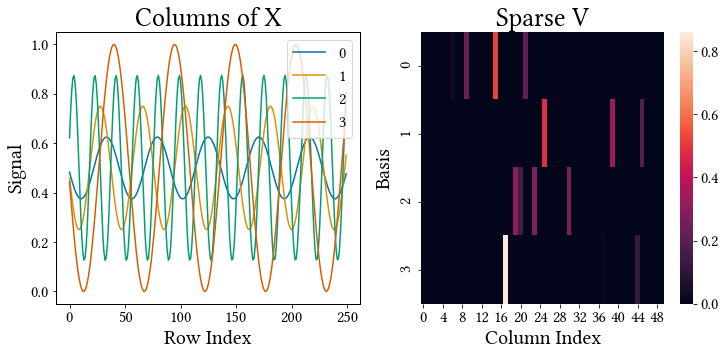

In [109]:
fig, ax = plt.subplots(1,2,figsize = (12,5))
W.plot(ax=ax[0])
ax[0].set_title("Columns of X", fontsize = 26)
ax[0].set_xlabel("Row Index", fontsize = 20)
ax[0].set_ylabel("Signal", fontsize = 20)
sns.heatmap(H, square = False, cbar = True, ax = ax[1])
ax[1].set_title("Sparse V", fontsize = 26)
ax[1].set_xlabel("Column Index", fontsize = 20)
ax[1].set_ylabel("Basis", fontsize = 20)
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/synthetic_4.pdf')

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


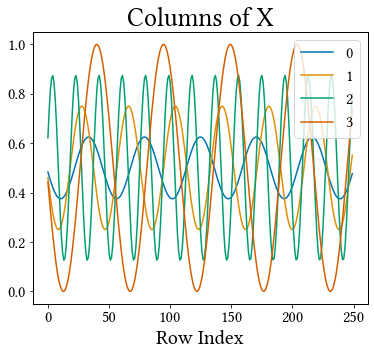

In [114]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
W.plot(ax=ax)
ax.set_title("Columns of X", fontsize = 26)
ax.set_xlabel("Row Index", fontsize = 20)
#ax.set_ylabel("Signal", fontsize = 20)
fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/synthetic_4.1.pdf')

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


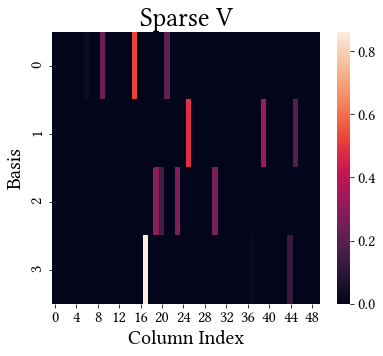

In [111]:
fig, ax = plt.subplots(1,1,figsize = (6,5))
sns.heatmap(H, square = False, cbar = True, ax = ax)
ax.set_title("Sparse V", fontsize = 26)
ax.set_xlabel("Column Index", fontsize = 20)
ax.set_ylabel("Basis", fontsize = 20)
fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/synthetic_4.2.pdf')

In [98]:
# calculate sparseness of H
# based on the hoyer definition of sparseness
def h_sparseness(h):
    h_sparse = 0
    for row in h.index:
        rh = np.array(h.loc[row,:])
        sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
        sp /= (math.sqrt(len(rh)) - 1)
        h_sparse += sp
    
    h_sparse /= len(h.index)
    
    return h_sparse

In [99]:
h_sparse = h_sparseness(H)
h_sparse

0.9020156637379071

In [100]:
G, lapl = gen_laplacian(size = m, radius = 0.30, state = rand_state)

In [101]:
beta = 1
I = np.identity(np.dot(W,H).shape[1])
#state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()
K = np.linalg.inv(I + beta*lapl)
D = np.dot(W, np.dot(H,K))

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


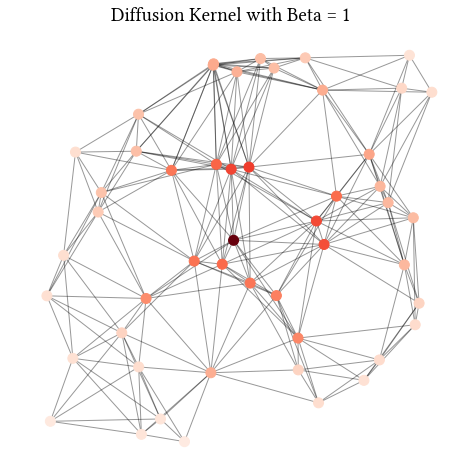

In [147]:
pos = nx.get_node_attributes(G, "pos")

# find node near center (0.5,0.5)
dmin = 1
ncenter = 0
for n in pos:
    x, y = pos[n]
    d = (x - 0.5) ** 2 + (y - 0.5) ** 2
    if d < dmin:
        ncenter = n
        dmin = d

# color by path length from node near center
#p = dict(nx.single_source_shortest_path_length(G, ncenter))
ks = preprocessing.MinMaxScaler().fit_transform(K)
p = {n: ks[ncenter,n] for n in pos.keys()}

plt.figure(figsize=(8, 8))
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_nodes(
    G,
    pos,
    nodelist=list(pos.keys()),
    node_size=100,
    #node_color=list(p.values()),
    node_color = ks[ncenter,:],
    cmap = plt.cm.Reds,
    vmin = 0,
    vmax = 0.4
)

plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.axis("off")
plt.title("Diffusion Kernel with Beta = 1")
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/synthetic_4.3.pdf')
plt.show()

### Initial Test

In [115]:
beta = 1
I = np.identity(np.dot(W,H).shape[1])
#state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()
K = np.linalg.inv(I + beta*lapl)
D = np.dot(W, np.dot(H,K))

<AxesSubplot:>

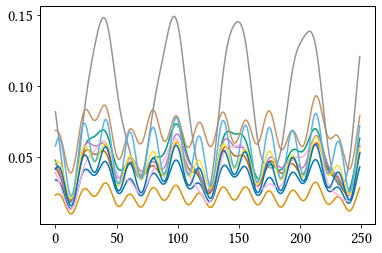

In [116]:
P = pd.DataFrame(D)
P.loc[:,10:20].plot(legend=False)

In [117]:
nmfer = nmf(n_components = 4, mask = None, n_iter = 100000, tol = 1e-9)
W_out, H_out = nmfer.fit_transform(D)

Max iterations reached, increase to converge on given tolerance


Text(0.5, 1.0, 'reconstructed H')

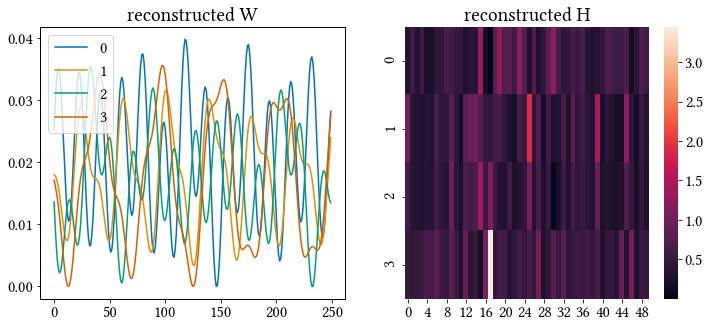

In [118]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
pd.DataFrame(W_out).plot(title = "reconstructed W", ax = ax[0])
sns.heatmap(H_out, square = False, cbar = True, ax = ax[1])
ax[1].set_title("reconstructed H")

In [119]:
differ = diffusionNMF(n_components = 4, kernel = K, mask = None, n_iter = 100000, tol = 1e-9)

In [120]:
X,V = differ.fit_transform(D)

Max iterations reached, increase to converge on given tolerance


Text(0.5, 1.0, 'reconstructed V')

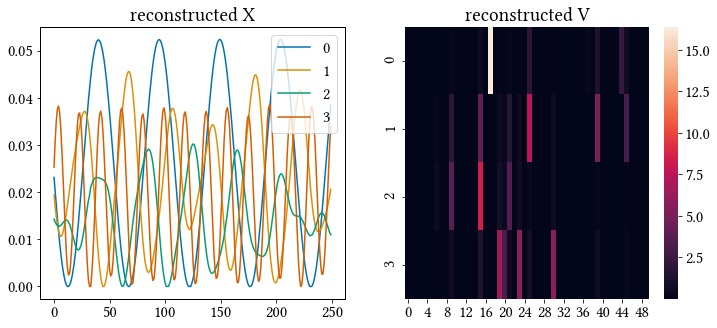

In [121]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
pd.DataFrame(X).plot(title = "reconstructed X", ax = ax[0])
sns.heatmap(V, square = False, cbar = True, ax = ax[1])
ax[1].set_title("reconstructed V")

Text(0.5, 1.0, 'Random Subset of Reconstructed Matrix')

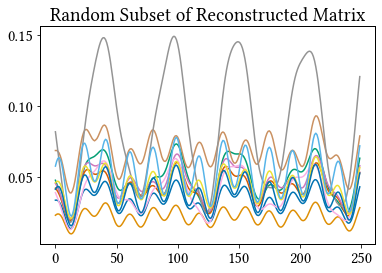

In [122]:
res = pd.DataFrame(X @ V @ K)
#rand_assort = random.choices(list(range(len(res.columns))), k = 10)
#res.plot(y = rand_assort)
res.loc[:,10:20].plot(legend = False)
plt.title("Random Subset of Reconstructed Matrix")

### Adding Noise

In [123]:
def noiser(matr, std_dev = None):
    # add noise to a matrix using gaussian random samples
    matr = np.matrix.copy(matr)
    if std_dev is None:
        std_dev = matr.std() / 100

    for rower in range(matr.shape[0]):
        for coler in range(matr.shape[1]):
            noisy = np.random.normal(scale = std_dev)
            if matr[rower, coler] + noisy < 0:
                matr[rower, coler] = 0
            else:
                matr[rower, coler] += noisy
    
            
    return matr

Text(0.5, 1.0, 'Subset of Data with Noise added')

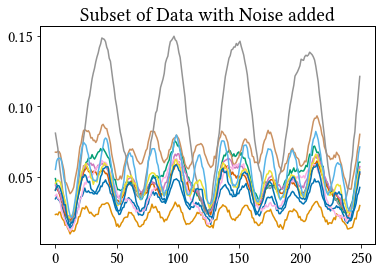

In [124]:
noise_D = noiser(D, 0.001)
pd.DataFrame(noise_D).loc[:,10:20].plot(legend=False)
plt.title("Subset of Data with Noise added")

### Hiding entries

In [125]:
# Creates a matrix of 0s -- unknown values -- and 1's -- known values ---
# in order to "mask" the data and split it into train/test sets
def train_mask(data, percent_hide):
    # "hide" a given percentage of the data
    num_entries = data.shape[0]*data.shape[1]
    mask = np.zeros(num_entries)
    mask[:int(num_entries * (1 - percent_hide))] = 1
    np.random.shuffle(mask)
    mask = mask.reshape(data.shape)
    
    return mask

In [126]:
hidden_mask = train_mask(noise_D, 0.2)

### Error Baseline

In [127]:
def ground_error(data, tests, n_avg = 10, noise_base = 0.001, percent_hide = 0.2):
    ground_error = np.zeros(tests)
    ground_std = np.zeros(tests)
    
    for t in range(tests):
        g_err = np.zeros(n_avg)
        for n in range(n_avg):
            noise_D = noiser(data, noise_base)
            hidden_mask = train_mask(noise_D, 0.2)
            g_err[n] = np.linalg.norm((1 - hidden_mask) * (noise_D - data)) / np.linalg.norm((1 - hidden_mask) * data)
            
        ground_error[t] = g_err.mean()
        ground_std[t] = g_err.std()
        
    return ground_error, ground_std

In [129]:
rank = 4
beta = 1
noise_base = 0.001
W,H = gen_decomposition(n, m, rank, state = rand_state)
G, lapl = gen_laplacian(size = m, radius = 0.30, state = rand_state)
K = np.linalg.inv(I + beta*lapl)
D = np.dot(W, np.dot(H, K))

In [130]:
# Holding true rank at 4:
ranks = list(range(1,15))
betas = np.array([1])
n_avg = 10

ground, ground_std = ground_error(D, len(ranks), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)

nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
nmf_res = nG.grid_search(ranks, betas)

dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
diff_res = dG.grid_search(ranks, betas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 140 out of 140 | elapsed:  6.2min finished


'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


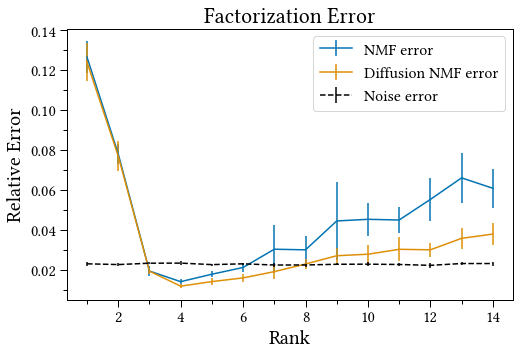

In [159]:
ranks = list(range(1,15))
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(ranks, nmf_res["relative error"], nmf_res["std error"], label = "NMF error")
ax.errorbar(ranks, diff_res["relative error"], diff_res["std error"], label = "Diffusion NMF error")
ax.errorbar(ranks, ground, ground_std, color = "k", linestyle = "--", label = "Noise error")
ax.set_xlabel("Rank", fontsize = 20)
ax.set_ylabel("Relative Error", fontsize = 20)
ax.set_title("Factorization Error", fontsize = 22)
plt.legend()
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/rank_error.pdf')

In [160]:
# Holding true beta at 1:
ranks = [4]
betas = np.linspace(0.01,2,15)
n_avg = 10

ground2, ground_std2 = ground_error(D, len(betas), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)

nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
nmf_res2 = nG.grid_search(ranks, betas)

dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
diff_res2 = dG.grid_search(ranks, betas)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   21.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.8min finished


'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


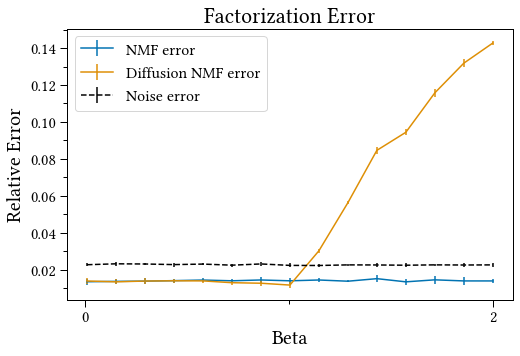

In [163]:
fig, ax = plt.subplots(1,1, figsize = (8,5))
ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(2))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(0.01))

ax.errorbar(betas, nmf_res2["relative error"], nmf_res2["std error"], label = "NMF error")
ax.errorbar(betas, diff_res2["relative error"], nmf_res2["std error"], label = "Diffusion NMF error")
ax.errorbar(betas, ground2, ground_std2, color = "k", linestyle = "--", label = "Noise error")
ax.set_xlabel("Beta", fontsize = 20)
ax.set_ylabel("Relative Error", fontsize = 20)
ax.set_title("Factorization Error", fontsize = 22)
plt.legend()
plt.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/beta_error.pdf')

In [46]:
beta = 1
rank_tests = range(1,15)
ground3 = np.zeros(len(rank_tests))
nmf_res3 = np.zeros(len(rank_tests))
diff_res3 = np.zeros(len(rank_tests))
n_avg = 10

for r in rank_tests:
    W,H = gen_decomposition(n, m, r, state = rand_state)
    G, lapl = gen_laplacian(size = m, H = H, p_edge = 0.05, state = rand_state)
    K = np.linalg.inv(I + beta * lapl)
    D = np.dot(W, np.dot(H,K))
    
    ranks = [r]
    betas = [beta]
    
    g_err = ground_error(D, len(ranks), n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)
    ground3[r - 1] = g_err

    nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
    n_err = nG.grid_search(ranks, betas)
    nmf_res3[r - 1] = n_err.loc[0, "relative error"]
    
    dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
    d_err = dG.grid_search(ranks, betas)
    diff_res3[r - 1] = d_err.loc[0, "relative error"]
    

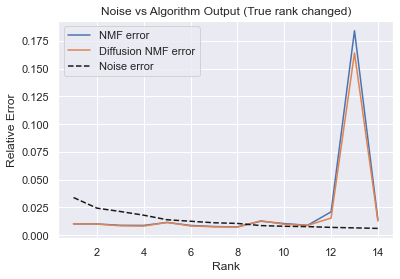

In [47]:
plt.plot(rank_tests, nmf_res3, label = "NMF error")
plt.plot(rank_tests, diff_res3, label = "Diffusion NMF error")
plt.plot(rank_tests, ground3, "k--", label = "Noise error")
plt.xlabel("Rank")
plt.ylabel("Relative Error")
plt.title("Noise vs Algorithm Output (True rank changed)")
plt.legend()

In [48]:
rank = 4
beta_tests = np.linspace(0.1,2,15)
ground4 = np.zeros(len(beta_tests))
nmf_res4 = np.zeros(len(beta_tests))
diff_res4 = np.zeros(len(beta_tests))
n_avg = 10

for b in range(len(beta_tests)):
    W,H = gen_decomposition(n, m, rank, state = rand_state)
    G, lapl = gen_laplacian(size = m, H = H, p_edge = 0.05, state = rand_state)
    K = np.linalg.inv(I + beta_tests[b] * lapl)
    D = np.dot(W, np.dot(H,K))
    
    ranks = [rank]
    betas = [beta_tests[b]]
    
    g_err = ground_error(D, 1, n_avg = n_avg, noise_base = noise_base, percent_hide = 0.2)
    ground4[b] = g_err

    nG = gridSearcher(D, algorithm = "nmf", percent_hide = 0.2, noise = noise_base, validate = n_avg)
    n_err = nG.grid_search(ranks, betas)
    nmf_res4[b] = n_err.loc[0, "relative error"]
    
    dG = gridSearcher(D, laplacian = lapl, algorithm = "diffusion", percent_hide = 0.2, noise = noise_base, validate = n_avg)
    d_err = dG.grid_search(ranks, betas)
    diff_res4[b] = d_err.loc[0, "relative error"]

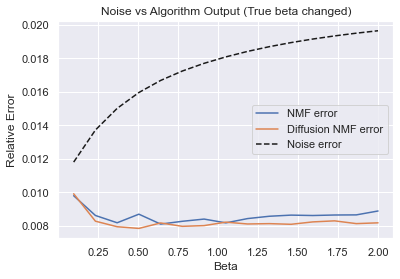

In [49]:
plt.plot(beta_tests, nmf_res4, label = "NMF error")
plt.plot(beta_tests, diff_res4, label = "Diffusion NMF error")
plt.plot(beta_tests, ground4, "k--", label = "Noise error")
plt.xlabel("Beta")
plt.ylabel("Relative Error")
plt.title("Noise vs Algorithm Output (True beta changed)")
plt.legend()

### Grid Search

In [6]:
t_data = pd.read_csv("./testing_data/grid_search_4_1.csv", index_col = 0)

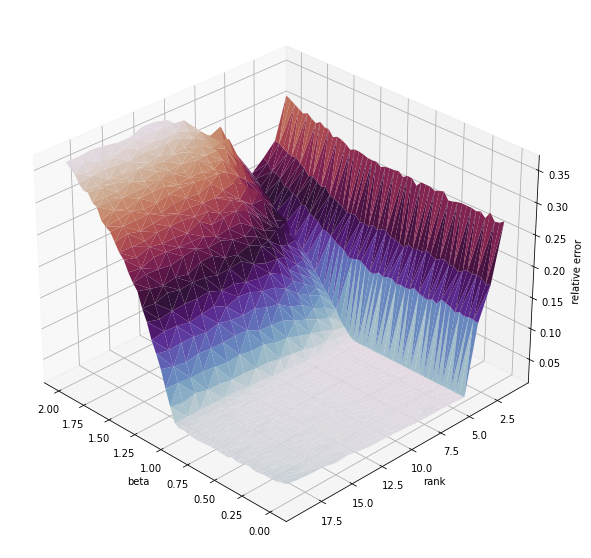

In [7]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(t_data['beta'], t_data['rank'], t_data['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,135)

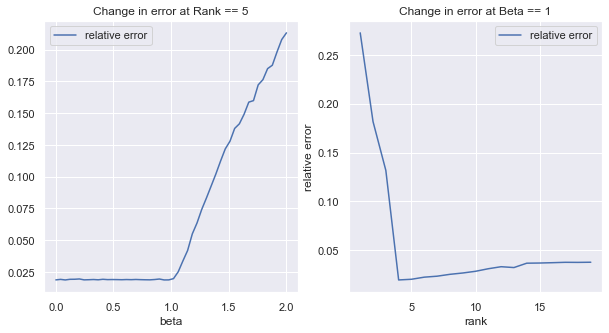

In [9]:
t_rank = t_data.loc[t_data["rank"] == 4]
f = t_data[t_data["beta"] >= 1].iloc[0]["beta"]
t_beta = t_data.loc[t_data["beta"] == f]

fix, ax = plt.subplots(1,2,figsize = (10,5))
t_rank.plot(x="beta", y="relative error", ax = ax[0])
ax[0].set_title("Change in error at Rank == 4")
t_beta.plot(x="rank", y="relative error", ax = ax[1])
ax[1].set_title("Change in error at Beta == 1")
plt.ylabel("relative error")
plt.legend()

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


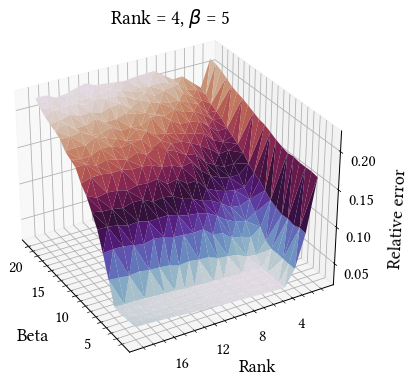

In [213]:
grid_4_5 = pd.read_csv("./testing_data/grid_search_4_5.csv") 
#grid_10_10 = grid_10_10.loc[grid_10_10["relative error"] < 0.5]
fig = plt.figure(figsize = (14,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid_4_5['beta'], grid_4_5['rank'], grid_4_5['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("Rank = 4, " + r'$\beta$ = 5')
ax.view_init(30,150)
ax.dist = 9

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_4.5.pdf')

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


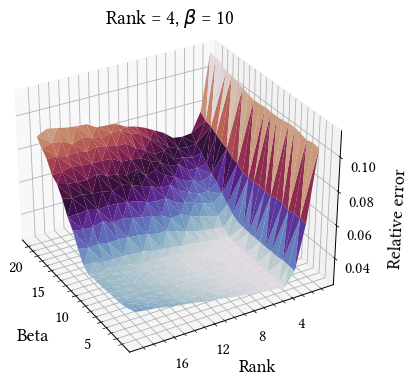

In [208]:
grid_4_10 = pd.read_csv("./testing_data/grid_search_4_10_6.csv") 
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid_4_10['beta'], grid_4_10['rank'], grid_4_10['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("Rank = 4, " + r'$\beta$ = 10')
ax.view_init(30,150)
ax.dist = 9

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_4.10.pdf')

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


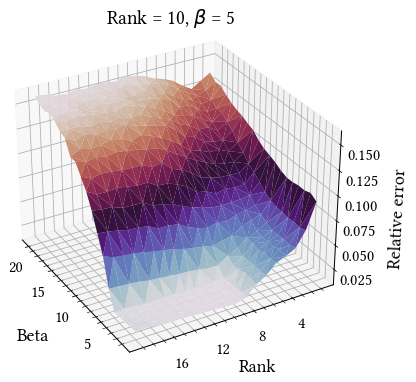

In [209]:
grid_10_5 = pd.read_csv("./testing_data/grid_search_10_5.csv") 
#grid_10_5 = grid_10_5.loc[grid_10_5["beta"] <= 6]
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid_10_5['beta'], grid_10_5['rank'], grid_10_5['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("Rank = 10, " + r'$\beta$ = 5')
ax.view_init(30,150)
ax.dist = 9

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_10.5.pdf')

'LinLibertine_R.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


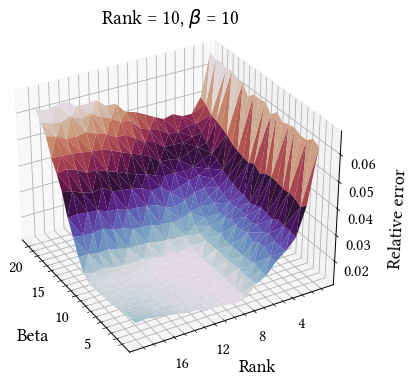

In [210]:
grid_10_10 = pd.read_csv("./testing_data/grid_search_10_10.csv") 
#grid_10_10 = grid_10_10.loc[grid_10_10["relative error"] < 0.5]
fig = plt.figure(figsize = (10,6))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid_10_10['beta'], grid_10_10['rank'], grid_10_10['relative error'], cmap=plt.cm.twilight, linewidth=0.2)

ax.xaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.xaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='major', size=7, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=4, width=1, direction='out')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(1))

ax.set_xlabel("Beta", fontsize = 18, labelpad = 13)
ax.set_ylabel("Rank", fontsize = 18, labelpad = 10)
ax.set_zlabel("Relative error", fontsize = 18, labelpad = 10)
ax.set_title("Rank = 10, " + r'$\beta$ = 10')
ax.view_init(30,150)
ax.dist = 9

fig.savefig('C:/Users/kq146/code/covid_college_tracker/diff_nmf_paper/figures/grid_10.10.pdf')

Text(0.5, 0, 'Relative Error')

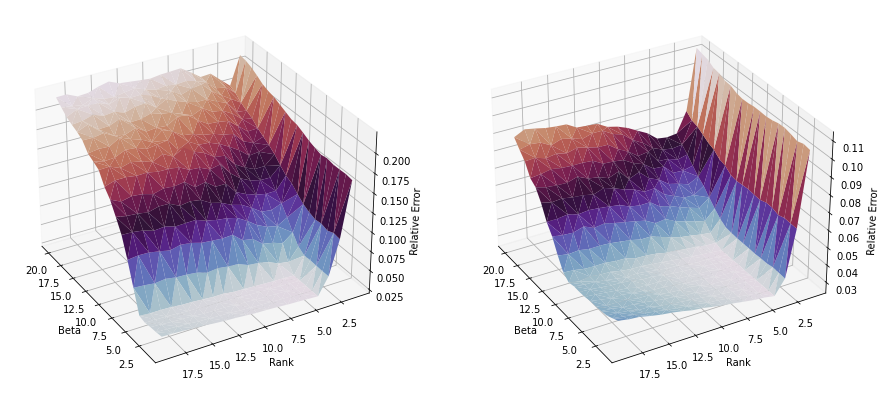

In [22]:
fig1 = plt.figure(figsize = (15,15))

ax11 = fig1.add_subplot(1,2,1, projection = '3d')
ax11.plot_trisurf(grid_4_5['beta'], grid_4_5['rank'], grid_4_5['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
ax11.view_init(30,150)
ax11.set_xlabel("Beta")
ax11.set_ylabel("Rank")
ax11.set_zlabel("Relative Error")

ax12 = fig1.add_subplot(1,2,2, projection = '3d')
ax12.plot_trisurf(grid_4_10['beta'], grid_4_10['rank'], grid_4_10['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
ax12.view_init(30,150)
ax12.set_xlabel("Beta")
ax12.set_ylabel("Rank")
ax12.set_zlabel("Relative Error")


Text(0.5, 0, 'Relative Error')

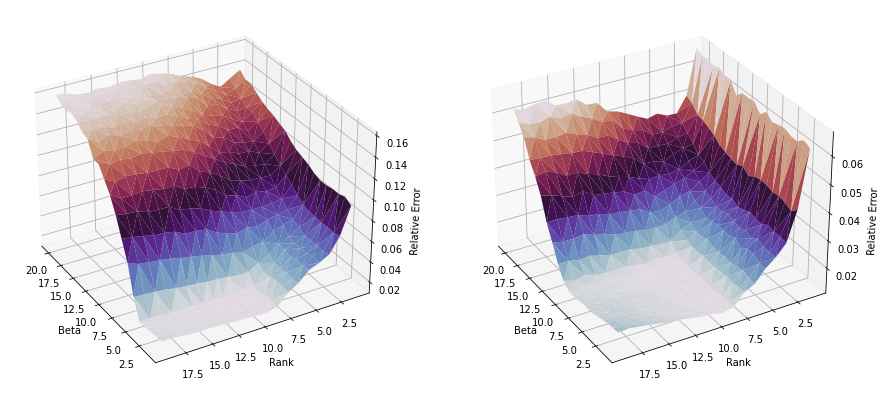

In [24]:
fig2 = plt.figure(figsize = (15,15))

ax21 = fig2.add_subplot(1,2,1, projection = '3d')
ax21.plot_trisurf(grid_10_5['beta'], grid_10_5['rank'], grid_10_5['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
ax21.view_init(30,150)
ax21.set_xlabel("Beta")
ax21.set_ylabel("Rank")
ax21.set_zlabel("Relative Error")

ax22 = fig2.add_subplot(1,2,2, projection = '3d')
ax22.plot_trisurf(grid_10_10['beta'], grid_10_10['rank'], grid_10_10['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
ax22.view_init(30,150)
ax22.set_xlabel("Beta")
ax22.set_ylabel("Rank")
ax22.set_zlabel("Relative Error")

In [25]:
grid_4_20 = pd.read_csv("./testing_data/grid_search_4_20.csv", index_col = 0)

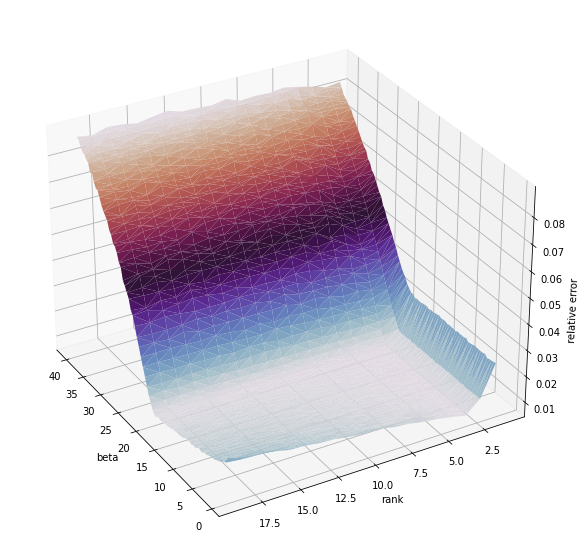

In [12]:
fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection='3d')
ax.plot_trisurf(grid_4_20['beta'], grid_4_20['rank'], grid_4_20['relative error'], cmap=plt.cm.twilight, linewidth=0.2)
plt.xlabel("beta")
plt.ylabel("rank")
ax.set_zlabel("relative error")
ax.view_init(30,150)

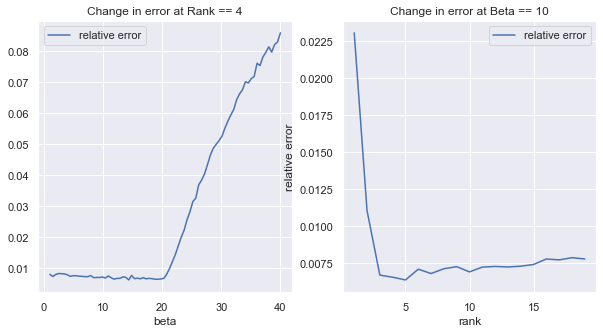

In [17]:
gr_rank = grid_4_20.loc[grid_4_20["rank"] == 4]
f = grid_4_20[grid_4_20["beta"] >= 20].iloc[0]["beta"]
gr_beta = grid_4_20.loc[grid_4_20["beta"] == f]

fix, ax = plt.subplots(1,2,figsize = (10,5))
gr_rank.plot(x="beta", y="relative error", ax = ax[0])
ax[0].set_title("Change in error at Rank == 4")
gr_beta.plot(x="rank", y="relative error", ax = ax[1])
ax[1].set_title("Change in error at Beta == 10")
plt.ylabel("relative error")
plt.legend()